
Statistical Analysis: Relationship between unemployment_rate and Poverty Rate

1. Linear Regression Analysis:
------------------------------
                            OLS Regression Results                            
Dep. Variable:           poverty_rate   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.440
Date:                Sat, 07 Dec 2024   Prob (F-statistic):              0.119
Time:                        15:04:21   Log-Likelihood:                 2779.6
No. Observations:                 280   AIC:                            -5555.
Df Residuals:                     278   BIC:                            -5548.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [

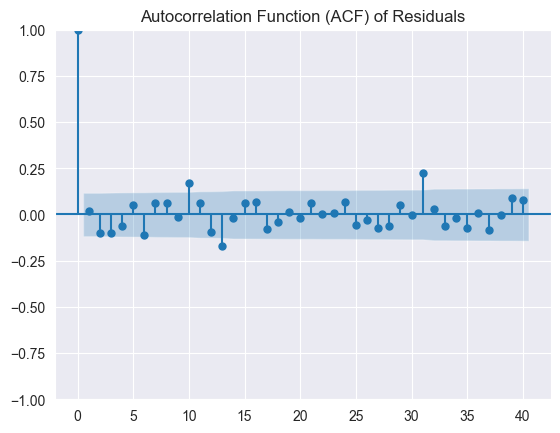

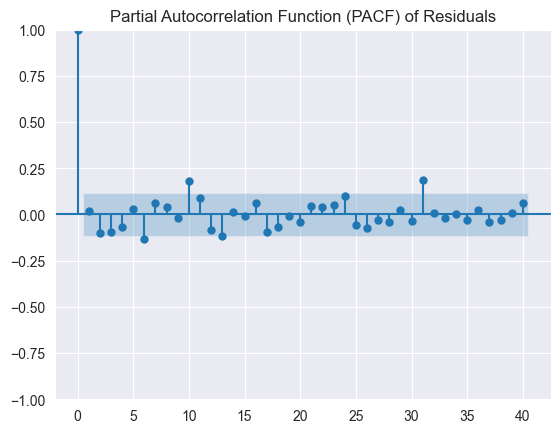

Durbin-Watson statistic: 1.952
No significant autocorrelation detected

3. ANOVA Analysis:
------------------------------
                            sum_sq     df         F   PR(>F)
C(unemployment_rate)  3.263291e-08  235.0  0.897324  0.69988
Residual              6.809124e-09   44.0       NaN      NaN

ANOVA Evaluation:
F-statistic: 0.897
p-value: 0.6999
No significant difference between groups

4. Bootstrap Analysis:
------------------------------
Bootstrap Analysis Summary:
Mean t-statistic: -1.356
Standard deviation of t-statistics: 0.950
95% Confidence Interval: [-3.126, 0.537]

Robustness Assessment:
Proportion of positive effects: 7.9%
Effect direction shows moderate robustness

Analysis Summary:
1. Linear Relationship: Not significant
2. Model Explanatory Power: 0.9%
3. Residual Autocorrelation: Not present
4. Group Difference: Not significant
5. Bootstrap Robustness: Moderate


In [5]:
import pandas as pd  
import statsmodels.api as sm  
import matplotlib.pyplot as plt  
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  
import statsmodels.formula.api as smf  
import numpy as np  

dataset = pd.read_csv('Data/all_in_one_data.csv')  

def judge_relevance(dataset_df, x_name, n_bootstraps=1000):  
    print("\n" + "="*50)  
    print(f"Statistical Analysis: Relationship between {x_name} and Poverty Rate")  
    print("="*50)  
    
    # 1. Linear Regression Analysis  
    print("\n1. Linear Regression Analysis:")  
    print("-"*30)  
    x = dataset_df[[x_name]]  
    y = dataset_df['poverty_rate']  
    x = sm.add_constant(x)  
    model = sm.OLS(y, x).fit()  
    print(model.summary())  
    
    # Evaluate regression results  
    print(f"\nModel Evaluation:")  
    print(f"R-squared: {model.rsquared:.3f} - Explains {model.rsquared*100:.1f}% of variance")  
    print(f"Adjusted R-squared: {model.rsquared_adj:.3f}")  
    if model.f_pvalue < 0.05:  
        print(f"Model is statistically significant (p-value = {model.f_pvalue:.4f})")  
    else:  
        print(f"Model is not statistically significant (p-value = {model.f_pvalue:.4f})")  
    
    # 2. Residual Analysis  
    print("\n2. Residual Analysis:")  
    print("-"*30)  
    print("Checking for autocorrelation...")  
    plot_acf(model.resid, lags=40)  
    plt.title("Autocorrelation Function (ACF) of Residuals")  
    plt.show()  
    plot_pacf(model.resid, lags=40)  
    plt.title("Partial Autocorrelation Function (PACF) of Residuals")  
    plt.show()  
    
    # Calculate Durbin-Watson statistic  
    dw_stat = sm.stats.stattools.durbin_watson(model.resid)  
    print(f"Durbin-Watson statistic: {dw_stat:.3f}")  
    if dw_stat < 1.5:  
        print("Positive autocorrelation detected")  
    elif dw_stat > 2.5:  
        print("Negative autocorrelation detected")  
    else:  
        print("No significant autocorrelation detected")  
    
    # 3. ANOVA Analysis  
    print("\n3. ANOVA Analysis:")  
    print("-"*30)  
    dataset_df['Higher'] = dataset_df[x_name] > dataset_df[x_name].mean()  
    anova_model = smf.ols(f'poverty_rate ~ C({x_name})', data=dataset_df).fit()  
    anova_table = sm.stats.anova_lm(anova_model, typ=2)  
    print(anova_table)  
    
    # Evaluate ANOVA results  
    f_stat = anova_table.iloc[0]['F']  
    p_val = anova_table.iloc[0]['PR(>F)']  
    print(f"\nANOVA Evaluation:")  
    print(f"F-statistic: {f_stat:.3f}")  
    print(f"p-value: {p_val:.4f}")  
    if p_val < 0.05:  
        print("Significant difference between groups detected")  
    else:  
        print("No significant difference between groups")  
    
    # 4. Bootstrap Analysis  
    print("\n4. Bootstrap Analysis:")  
    print("-"*30)  
    t_stats = []  
    for _ in range(n_bootstraps):  
        sample = dataset_df.sample(frac=1, replace=True)  
        high_group = sample[sample['Higher']]  
        low_group = sample[~sample['Higher']]  
        t_stat, _, _ = sm.stats.ttest_ind(high_group['poverty_rate'],   
                                        low_group['poverty_rate'])  
        t_stats.append(t_stat)  
    
    # Analyze t-statistic distribution  
    t_stats = np.array(t_stats)  
    print(f"Bootstrap Analysis Summary:")  
    print(f"Mean t-statistic: {np.mean(t_stats):.3f}")  
    print(f"Standard deviation of t-statistics: {np.std(t_stats):.3f}")  
    print(f"95% Confidence Interval: [{np.percentile(t_stats, 2.5):.3f}, {np.percentile(t_stats, 97.5):.3f}]")  
    
    # Assess robustness  
    positive_ratio = np.mean(t_stats > 0)  
    print(f"\nRobustness Assessment:")  
    print(f"Proportion of positive effects: {positive_ratio:.1%}")  
    if positive_ratio > 0.95 or positive_ratio < 0.05:  
        print("Effect direction shows strong robustness")  
    elif positive_ratio > 0.8 or positive_ratio < 0.2:  
        print("Effect direction shows moderate robustness")  
    else:  
        print("Effect direction is unstable")  
    
    print("\n" + "="*50)  
    print("Analysis Summary:")  
    print("="*50)  
    print(f"1. Linear Relationship: {'Significant' if model.f_pvalue < 0.05 else 'Not significant'}")  
    print(f"2. Model Explanatory Power: {model.rsquared*100:.1f}%")  
    print(f"3. Residual Autocorrelation: {'Present' if dw_stat < 1.5 or dw_stat > 2.5 else 'Not present'}")  
    print(f"4. Group Difference: {'Significant' if p_val < 0.05 else 'Not significant'}")  
    print(f"5. Bootstrap Robustness: {'High' if positive_ratio > 0.95 or positive_ratio < 0.05 else 'Moderate' if positive_ratio > 0.8 or positive_ratio < 0.2 else 'Low'}")  

# Run analysis  
judge_relevance(dataset, 'unemployment_rate') # 这里换成其他变量, 就可以分析其他变量